In [1]:
import numpy as np 
import pandas as pd 

In [5]:
df = pd.read_csv("full_df.csv")
df.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg


In [6]:
def has_cataract(text):
    if "cataract" in text:
        return 1
    else:
        return 0

In [7]:
df["left_cataract"] = df["Left-Diagnostic Keywords"].apply(lambda x: has_cataract(x))
df["right_cataract"] = df["Right-Diagnostic Keywords"].apply(lambda x: has_cataract(x))

In [8]:
left_cataract = df.loc[(df.C ==1) & (df.left_cataract == 1)]["Left-Fundus"].values
left_cataract[:15]

array(['0_left.jpg', '81_left.jpg', '103_left.jpg', '119_left.jpg',
       '254_left.jpg', '294_left.jpg', '330_left.jpg', '448_left.jpg',
       '465_left.jpg', '477_left.jpg', '553_left.jpg', '560_left.jpg',
       '594_left.jpg', '611_left.jpg', '625_left.jpg'], dtype=object)

In [9]:
right_cataract = df.loc[(df.C ==1) & (df.right_cataract == 1)]["Right-Fundus"].values
right_cataract[:15]

array(['24_right.jpg', '81_right.jpg', '112_right.jpg', '188_right.jpg',
       '218_right.jpg', '345_right.jpg', '354_right.jpg', '477_right.jpg',
       '553_right.jpg', '560_right.jpg', '625_right.jpg', '726_right.jpg',
       '769_right.jpg', '949_right.jpg', '955_right.jpg'], dtype=object)

In [10]:
print("Number of images in left cataract: {}".format(len(left_cataract)))
print("Number of images in right cataract: {}".format(len(right_cataract)))

Number of images in left cataract: 304
Number of images in right cataract: 290


In [11]:
left_normal = df.loc[(df.C ==0) & (df["Left-Diagnostic Keywords"] == "normal fundus")]["Left-Fundus"].sample(250,random_state=42).values
right_normal = df.loc[(df.C ==0) & (df["Right-Diagnostic Keywords"] == "normal fundus")]["Right-Fundus"].sample(250,random_state=42).values
right_normal[:15]

array(['2964_right.jpg', '680_right.jpg', '500_right.jpg',
       '2368_right.jpg', '2820_right.jpg', '2769_right.jpg',
       '2696_right.jpg', '2890_right.jpg', '940_right.jpg',
       '2553_right.jpg', '3371_right.jpg', '3042_right.jpg',
       '919_right.jpg', '3427_right.jpg', '379_right.jpg'], dtype=object)

In [12]:
cataract = np.concatenate((left_cataract,right_cataract),axis=0)
normal = np.concatenate((left_normal,right_normal),axis=0)

In [13]:
print(len(cataract),len(normal))

594 500


In [14]:
import cv2
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img,img_to_array
dataset_dir = "preprocessed_images"
image_size=224
labels = []
dataset = []
def create_dataset(image_category,label):
    for img in tqdm(image_category):
        image_path = os.path.join(dataset_dir,img)
        try:
            image = cv2.imread(image_path,cv2.IMREAD_COLOR)
            image = cv2.resize(image,(image_size,image_size))
        except:
            continue
        
        dataset.append([np.array(image),np.array(label)])
    random.shuffle(dataset)
    return dataset

In [16]:
import os
dataset = create_dataset(cataract,1)
len(dataset)

100%|██████████| 594/594 [00:04<00:00, 146.33it/s]


588

In [17]:
dataset = create_dataset(normal,0)
len(dataset)

100%|██████████| 500/500 [00:03<00:00, 128.97it/s]


1088

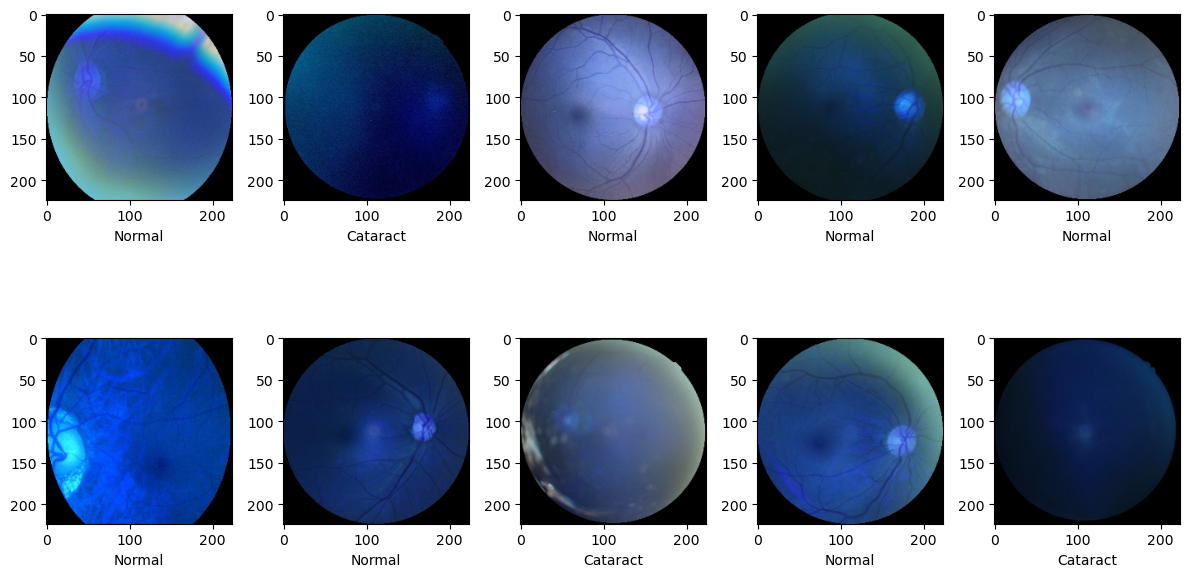

In [18]:
plt.figure(figsize=(12,7))
for i in range(10):
    sample = random.choice(range(len(dataset)))
    image = dataset[sample][0]
    category = dataset[sample][1]
    if category== 0:
        label = "Normal"
    else:
        label = "Cataract"
    plt.subplot(2,5,i+1)
    plt.imshow(image)
    plt.xlabel(label)
plt.tight_layout()   

In [19]:
x = np.array([i[0] for i in dataset]).reshape(-1,image_size,image_size,3)
y = np.array([i[1] for i in dataset])

In [20]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2)

In [21]:
from tensorflow.keras.applications.vgg19 import VGG19
vgg = VGG19(weights="imagenet",include_top = False,input_shape=(image_size,image_size,3))

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 15s 0us/step


In [22]:
for layer in vgg.layers:
    layer.trainable = False

In [23]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten,Dense
model1 = Sequential()
model1.add(vgg)
model1.add(Flatten())
model1.add(Dense(1,activation="sigmoid"))
model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)              │ ?                      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,024,384 (76.39 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 20,024,384 (76.39 MB)

In [24]:
model1.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])

In [29]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
checkpoint = ModelCheckpoint("vgg19.keras", monitor="val_acc", verbose=1, save_best_only=True, save_weights_only=False, save_freq='epoch')
earlystop = EarlyStopping(monitor="val_acc", mode='max', patience=5, verbose=1)

In [30]:
history1 = model1.fit(x_train,y_train,batch_size=32,epochs=10,validation_data=(x_test,y_test),
                    verbose=1,callbacks=[checkpoint,earlystop])

Epoch 1/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 139s 5s/step - accuracy: 0.9656 - loss: 0.3207 - val_accuracy: 0.8899 - val_loss: 1.1724
Epoch 2/10


C:\Users\sruja\anaconda3\Lib\site-packages\keras\src\callbacks\early_stopping.py:156: UserWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss
  current = self.get_monitor_value(logs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 159s 6s/step - accuracy: 0.9577 - loss: 0.3199 - val_accuracy: 0.9450 - val_loss: 0.6933
Epoch 3/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 160s 6s/step - accuracy: 0.9940 - loss: 0.0490 - val_accuracy: 0.9450 - val_loss: 0.5826
Epoch 4/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 161s 6s/step - accuracy: 0.9878 - loss: 0.0263 - val_accuracy: 0.9587 - val_loss: 0.7511
Epoch 5/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 158s 6s/step - accuracy: 0.9929 - loss: 0.0232 - val_accuracy: 0.9587 - val_loss: 0.5218
Epoch 6/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 158s 6s/step - accuracy: 0.9963 - loss: 0.0030 - val_accuracy: 0.9450 - val_loss: 0.5223
Epoch 7/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 154s 6s/step - accuracy: 1.0000 - loss: 2.8839e-05 - val_accuracy: 0.9541 - val_loss: 0.5525
Epoch 8/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 158s 6s/step - accuracy: 1.0000 - loss: 3.4941e-05 - val_accuracy: 0.9541 - val_loss: 0.5475
Epoch 9/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 157s 6s/step - accuracy: 1.0000 - loss: 1.6036e-05 - val_accuracy: 0.9541 - 

In [31]:
loss,accuracy = model1.evaluate(x_test,y_test)
print("loss:",loss)
print("Accuracy:",accuracy)

7/7 ━━━━━━━━━━━━━━━━━━━━ 26s 4s/step - accuracy: 0.9510 - loss: 0.2935
loss: 0.5397846698760986
Accuracy: 0.9541284441947937


In [32]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
y_pred1 = (model1.predict(x_test) > 0.5).astype("int32")
accuracy_score(y_test, y_pred1)

7/7 ━━━━━━━━━━━━━━━━━━━━ 29s 4s/step


0.9541284403669725

In [33]:
print(classification_report(y_test,y_pred1))

              precision    recall  f1-score   support

           0       0.98      0.91      0.95        94
           1       0.94      0.98      0.96       124

    accuracy                           0.95       218
   macro avg       0.96      0.95      0.95       218
weighted avg       0.96      0.95      0.95       218



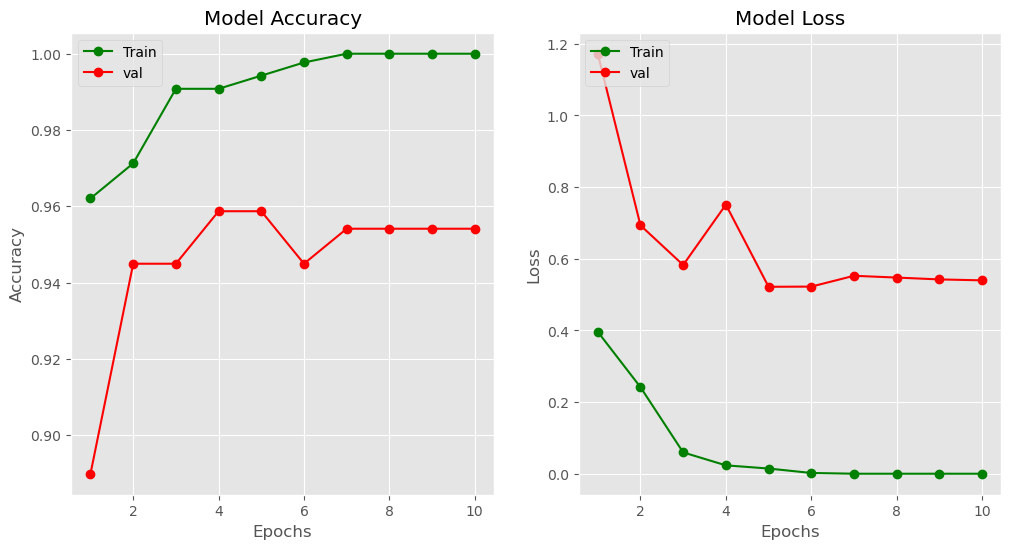

In [34]:
plt.style.use("ggplot")
fig = plt.figure(figsize=(12,6))
epochs = range(1,11)
plt.subplot(1,2,1)
plt.plot(epochs,history1.history["accuracy"],"go-")
plt.plot(epochs,history1.history["val_accuracy"],"ro-")
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Train","val"],loc = "upper left")

plt.subplot(1,2,2)
plt.plot(epochs,history1.history["loss"],"go-")
plt.plot(epochs,history1.history["val_loss"],"ro-")
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Train","val"],loc = "upper left")
plt.show()

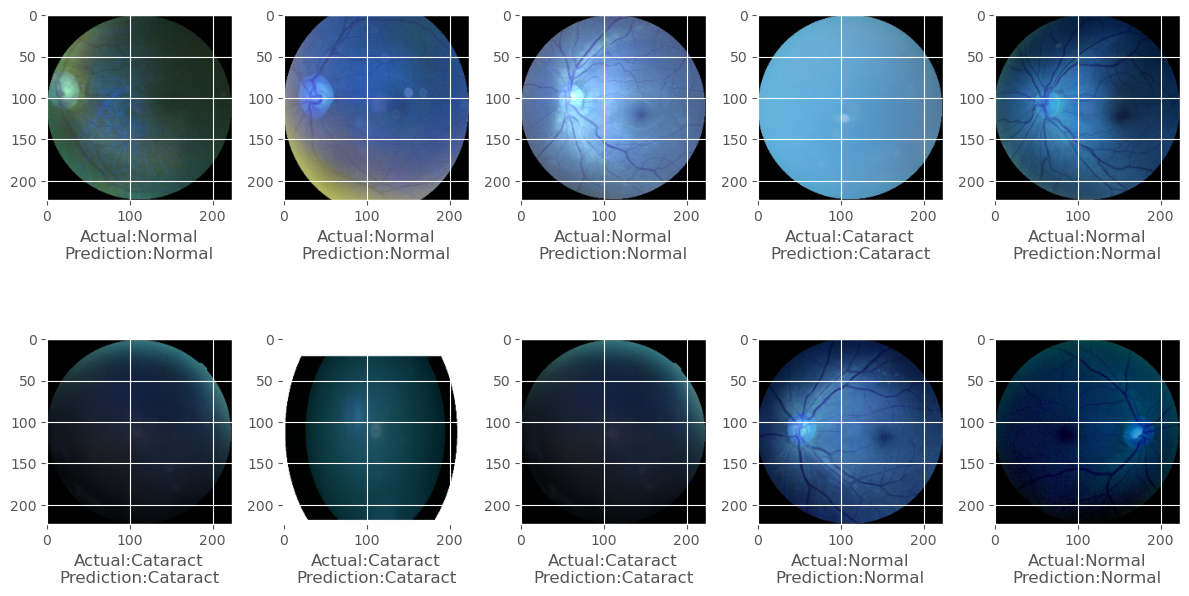

In [35]:
plt.figure(figsize=(12,7))
for i in range(10):
    sample = random.choice(range(len(x_test)))
    image = x_test[sample]
    category = y_test[sample]
    pred_category = y_pred1[sample]
    
    if category== 0:
        label = "Normal"
    else:
        label = "Cataract"
        
    if pred_category== 0:
        pred_label = "Normal"
    else:
        pred_label = "Cataract"
        
    plt.subplot(2,5,i+1)
    plt.imshow(image)
    plt.xlabel("Actual:{}\nPrediction:{}".format(label,pred_label))
plt.tight_layout() 